# Analysis of Electric Vehicle Charging Transactions (Users)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Display all columns
pd.set_option('display.max_columns', None)

# Set visualization style
sns.set_style('darkgrid')

In [2]:
# Read in the file
user_data = pd.read_excel(
    'SEND Public_Charging sessions data.xlsx',
    header=3,
    parse_dates = [4, 5]
)

In [3]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Nutzergruppe                   146 non-null    object        
 1   Kostenstelle                   0 non-null      float64       
 2   Nutzer/Fahrzeug                146 non-null    object        
 3   Ladekarte                      146 non-null    object        
 4   Eingesteckt am                 146 non-null    datetime64[ns]
 5   Ausgesteckt am                 147 non-null    object        
 6   Ladedauer                      147 non-null    object        
 7   Zeit angesteckt                147 non-null    object        
 8   Standort                       146 non-null    object        
 9   Ladestation                    146 non-null    object        
 10  Anschluss                      146 non-null    object        
 11  EVSE-ID            

# Data preprocessing

In [4]:
# Drop last two rows (redundant data)
user_data.drop([146, 147], inplace=True)

In [5]:
# Convert unplugged feature to datetime
user_data['Ausgesteckt am'] = pd.to_datetime(user_data['Ausgesteckt am'])

In [6]:
# Create a function to convert duration to hours
def duration_to_hours(duration):
    parts = duration.split(' ')
    hours = 0
    minutes = 0
    seconds = 0

    for part in parts:
        if 'h' in part:
            hours = int(part[:-1])
        elif 'm' in part:
            minutes = int(part[:-1])
        elif 's' in part:
            seconds = int(part[:-1])
    return (hours + (minutes / 60) + seconds / 3600)

In [7]:
# Convert Charge time to hours only
user_data['Charge time'] = user_data['Ladedauer'].apply(duration_to_hours)

# Convert Blocking time to hours only
user_data['Blocking time'] = user_data['Zeit angesteckt'].apply(duration_to_hours)

In [13]:
# Extract month when vehicles were plugged and unplugged
user_data['Plugged_in_month'] = user_data['Eingesteckt am'].dt.month
user_data['Unplugged_month'] = user_data['Ausgesteckt am'].dt.month

# Extract week when vehicles were plugged and unplugged
user_data['Plugged_in_week'] = user_data['Eingesteckt am'].dt.isocalendar().week.astype('int')
user_data['Unplugged_week'] = user_data['Ausgesteckt am'].dt.isocalendar().week.astype('int')

# Extract day when vehicles were plugged and unplugged
user_data['Plugged_in_day'] = user_data['Eingesteckt am'].dt.day
user_data['Unplugged_day'] = user_data['Ausgesteckt am'].dt.day

# Extract time when vehicles were plugged and unplugged
user_data['Plugged_in_time'] = user_data['Eingesteckt am'].dt.time
user_data['Unplugged_time'] = user_data['Ausgesteckt am'].dt.time

# Extract hour when vehicles were plugged and unplugged
user_data['Plugged_in_hour'] = user_data['Eingesteckt am'].dt.hour
user_data['Unplugged_hour'] = user_data['Ausgesteckt am'].dt.hour

In [74]:
user_data_daytime = user_data.set_index('Ausgesteckt am').between_time('6:00', '18:00').reset_index()
user_data_nighttime = user_data.set_index('Ausgesteckt am').between_time('18:01', '5:59').reset_index()

In [14]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Nutzergruppe                   146 non-null    object        
 1   Kostenstelle                   0 non-null      float64       
 2   Nutzer/Fahrzeug                146 non-null    object        
 3   Ladekarte                      146 non-null    object        
 4   Eingesteckt am                 146 non-null    datetime64[ns]
 5   Ausgesteckt am                 146 non-null    datetime64[ns]
 6   Ladedauer                      146 non-null    object        
 7   Zeit angesteckt                146 non-null    object        
 8   Standort                       146 non-null    object        
 9   Ladestation                    146 non-null    object        
 10  Anschluss                      146 non-null    object        
 11  EVSE-ID            

# Exploratory Data Analysis

### Number of unique public users

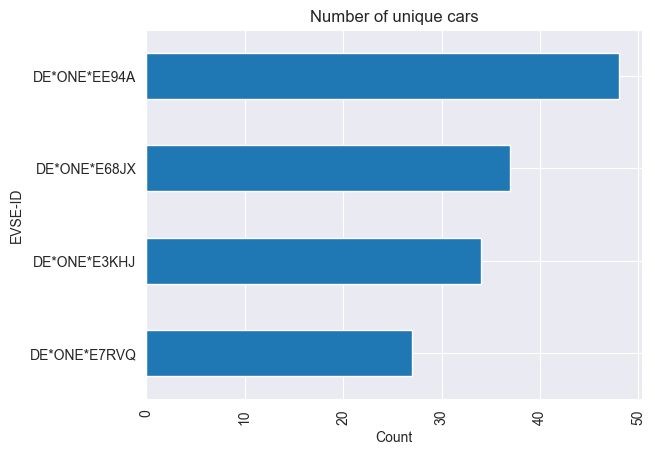

In [100]:
user_data['EVSE-ID'].value_counts(ascending=True).plot(kind='barh')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.title('Number of unique cars')
plt.savefig('Images/Public/unique-public-users.png', dpi=300, bbox_inches='tight')
plt.show()

### Rate/frequency of charge per user

<Axes: xlabel='Plugged_in_hour', ylabel='Charge time'>

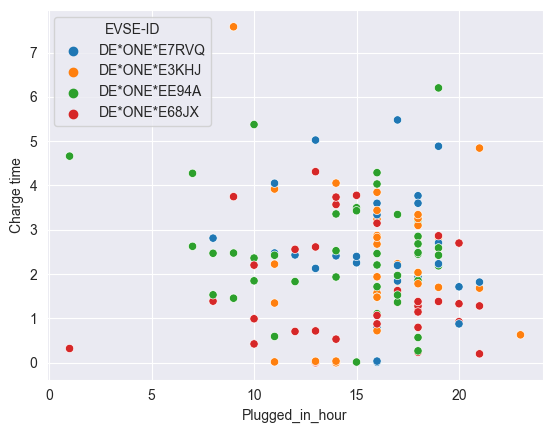

In [105]:
sns.scatterplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Charge time',
    hue='EVSE-ID',
 )

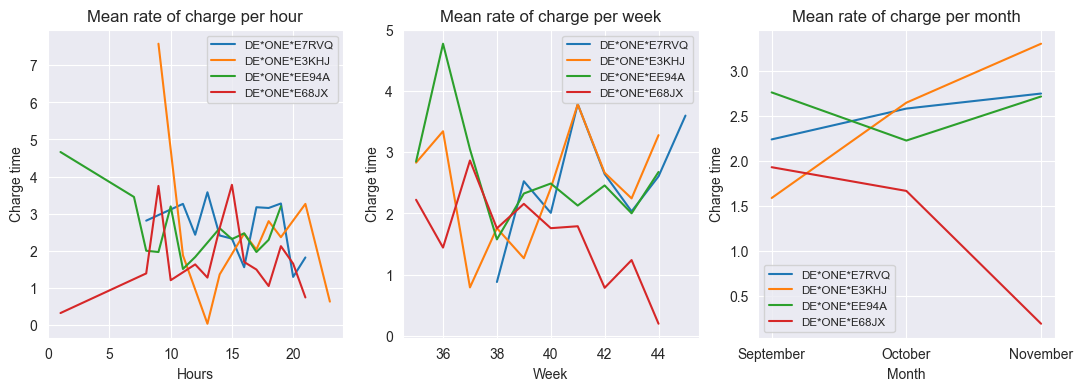

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
# Rate of charge (hourly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Charge time',
    hue='EVSE-ID',
    ci=None,
    ax=ax[0]
)
ax[0].legend(fontsize='small')
ax[0].set_title('Mean rate of charge per hour')
ax[0].set_xlabel('Hours')

# Rate of charge (weekly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_week',
    y='Charge time',
    hue='EVSE-ID',
    ci=None,
    ax=ax[1]
)
ax[1].set_title('Mean rate of charge per week')
ax[1].set_xlabel('Week')
ax[1].legend(fontsize='small')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Charge time',
    hue='EVSE-ID',
    ci=None,
    ax=ax[2]
)
ax[2].set_title('Mean rate of charge per month')
ax[2].set_xlabel('Month')
ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.legend(fontsize='small')
plt.savefig('Images/Public/rate-of-charge-of-users')
plt.show()

In [109]:
user_data_weekend = user_data[user_data['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]
user_data_weekend['Weekend'] = user_data['Eingesteckt am'].dt.day_name()

In [110]:
user_data_weekend['Weekend'] = user_data_weekend['Weekend'].map({
    'Saturday': 6,
    'Sunday': 7
})

In [23]:
#user_data_weekend[['EVSE-ID', 'Weekend', 'Eingesteckt am', 'Ausgesteckt am', 'Zeit angesteckt', 'Ladedauer', 'Standort', 'Ladestation', 'Charge time']]

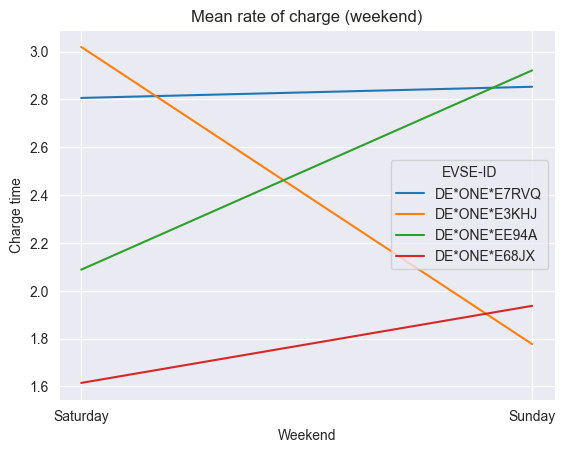

In [111]:
# Rate of charge (weekend)
sns.lineplot(
    data=user_data_weekend,
    x='Weekend',
    y='Charge time',
    hue='EVSE-ID',
    ci=None
)
plt.title('Mean rate of charge (weekend)')
plt.xlabel('Weekend')
plt.xticks([6, 7], labels=['Saturday', 'Sunday'])
plt.savefig('Images/Public/rate-of-charge-of-users-weekend')
plt.show()

### Rate of charge over the weekend

In [85]:
user_data_weekend = user_data[user_data['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]
user_data_weekend['Weekend'] = user_data['Eingesteckt am'].dt.day_name()

In [88]:
user_data_weekend['Weekend'] = user_data_weekend['Weekend'].map({
    'Saturday': 6,
    'Sunday': 7
})

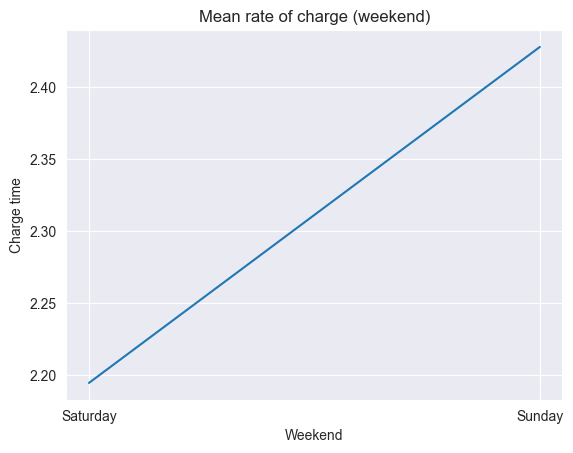

In [112]:
# Rate of charge (weekend)
sns.lineplot(
    data=user_data_weekend,
    x='Weekend',
    y='Charge time',
    ci=None
)
plt.title('Mean rate of charge (weekend)')
plt.xlabel('Weekend')
plt.xticks([6, 7], labels=['Saturday', 'Sunday'])
plt.savefig('Images/Public/rate-of-charge-weekend')
plt.show()

### Usage occupancy of charge points

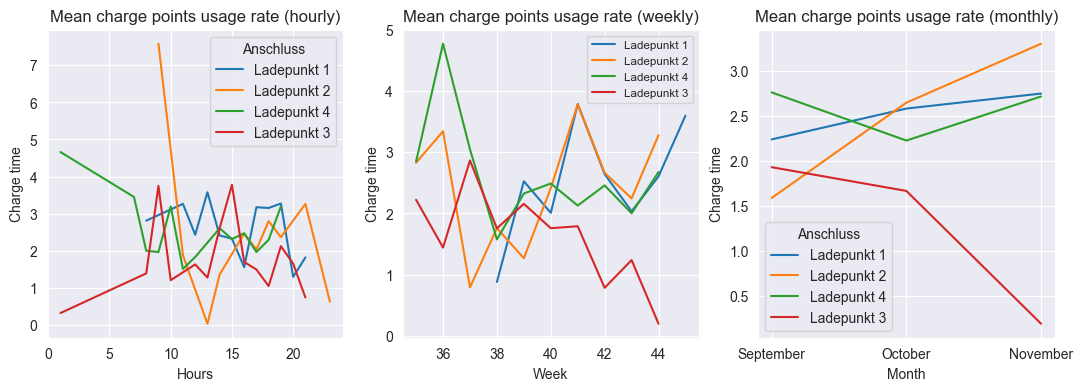

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
# Rate of charge (hourly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Charge time',
    hue='Anschluss',
    ci=None,
    ax=ax[0]
)
ax[0].set_title('Mean charge points usage rate (hourly)')
ax[0].set_xlabel('Hours')

# Rate of charge (weekly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_week',
    y='Charge time',
    hue='Anschluss',
    ci=None,
    ax=ax[1]
)
ax[1].set_title('Mean charge points usage rate (weekly)')
ax[1].set_xlabel('Week')
ax[1].legend(fontsize='small', loc='upper right')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Charge time',
    hue='Anschluss',
    ci=None,
    ax=ax[2]
)
ax[2].set_title('Mean charge points usage rate (monthly)')
ax[2].set_xlabel('Month')
ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.savefig('Images/Public/usage-occupancy-of-charge-points')
plt.show()

### Blocking time

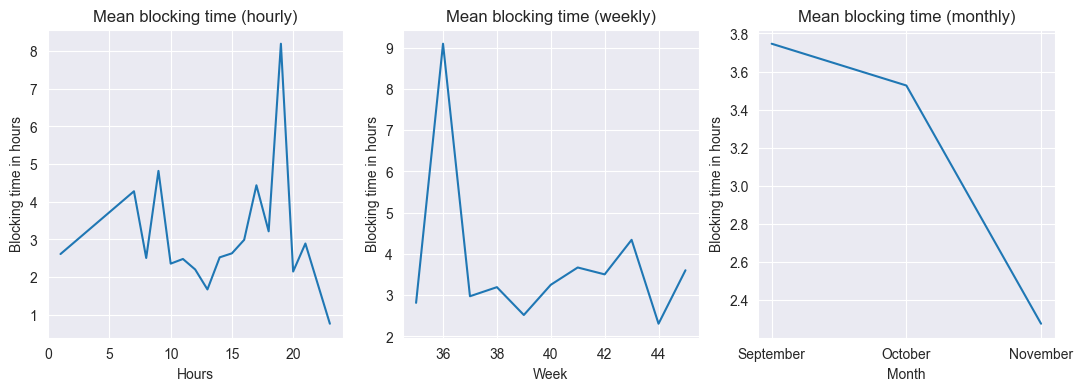

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
# Rate of charge (hourly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Blocking time',
    ci=None,
    ax=ax[0]
)
ax[0].set_title('Mean blocking time (hourly)')
ax[0].set_ylabel('Blocking time in hours')
ax[0].set_xlabel('Hours')

# Rate of charge (weekly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_week',
    y='Blocking time',
    ci=None,
    ax=ax[1]
)
ax[1].set_title('Mean blocking time (weekly)')
ax[1].set_xlabel('Week')
ax[1].set_ylabel('Blocking time in hours')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Blocking time',
    ci=None,
    ax=ax[2]
)
ax[2].set_title('Mean blocking time (monthly)')
ax[2].set_xlabel('Month')
ax[2].set_ylabel('Blocking time in hours')
ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.savefig('Images/Public/blocking-time')
plt.show()

### Hogging time

In [115]:
user_data['Hogging time'] = user_data['Blocking time'] - user_data['Charge time']

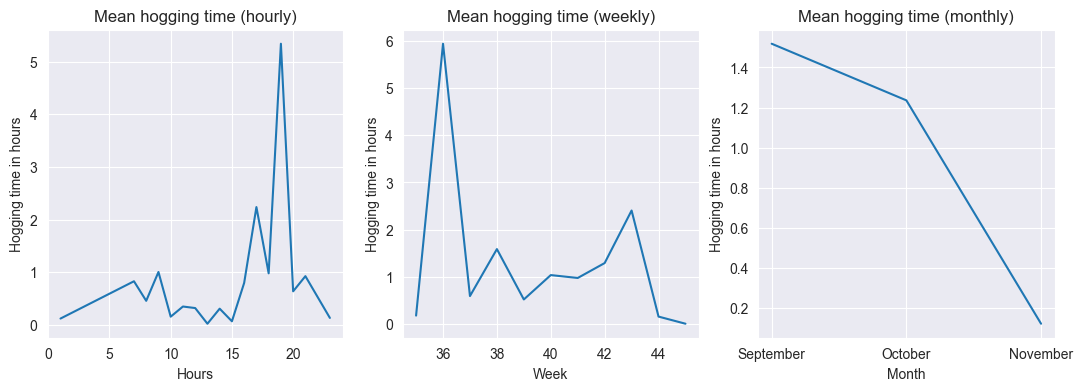

In [121]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
# Rate of charge (hourly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Hogging time',
    ci=None,
    ax=ax[0]
)
ax[0].set_title('Mean hogging time (hourly)')
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Hogging time in hours')

# Rate of charge (weekly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_week',
    y='Hogging time',
    ci=None,
    ax=ax[1]
)
ax[1].set_title('Mean hogging time (weekly)')
ax[1].set_xlabel('Week')
ax[1].set_ylabel('Hogging time in hours')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Hogging time',
    ci=None,
    ax=ax[2]
)
ax[2].set_title('Mean hogging time (monthly)')
ax[2].set_xlabel('Month')
ax[2].set_ylabel('Hogging time in hours')
ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.savefig('Images/Public/hogging-time')
plt.show()

### Day-time demand profile

In [122]:
user_data_daytime_weekend = user_data_daytime[user_data_daytime['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]
user_data_daytime_weekend['Weekend'] = user_data_daytime['Eingesteckt am'].dt.day_name()

In [124]:
user_data_daytime_weekend['Weekend'] = user_data_daytime_weekend['Weekend'].map({
    'Saturday': 6,
    'Sunday': 7
})

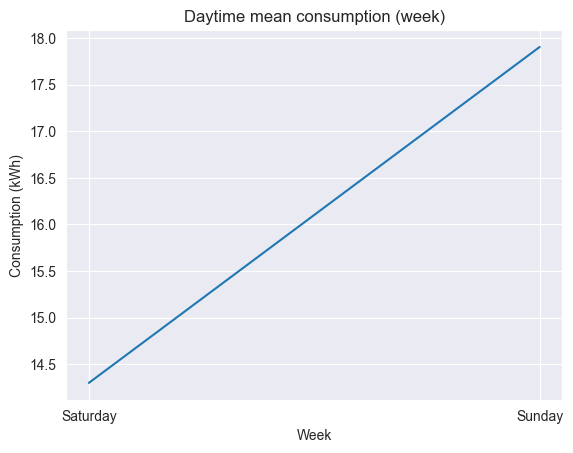

In [125]:
sns.lineplot(
    data=user_data_daytime_weekend,
    x='Weekend',
    y='Verbrauch (kWh)',
    ci=None
)
plt.xlabel('Week')
plt.ylabel('Consumption (kWh)')
plt.title('Daytime mean consumption (week)')
plt.xticks([6, 7], labels=['Saturday', 'Sunday'])
plt.savefig('Images/Public/daytime-demand-profile-weekend')
plt.show()

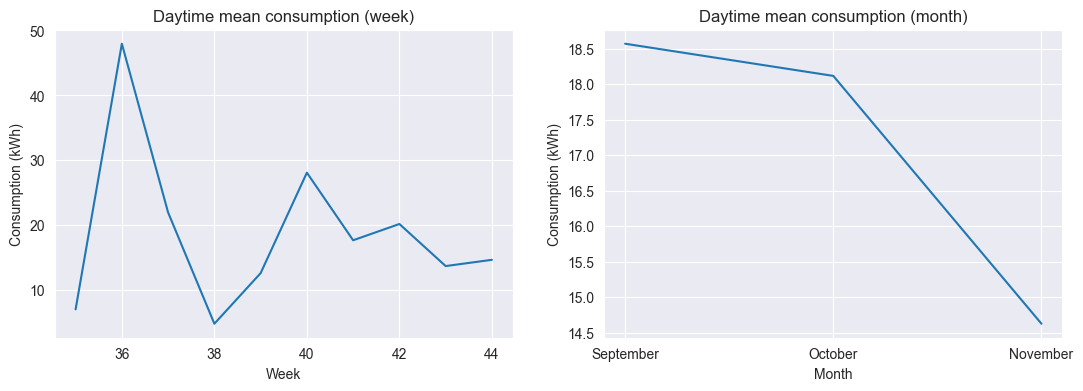

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# Rate of charge (weekly)
sns.lineplot(
    data=user_data_daytime,
    x='Plugged_in_week',
    y='Verbrauch (kWh)',
    ax=ax[0],
    ci=None
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Consumption (kWh)')
ax[0].set_title('Daytime mean consumption (week)')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data_daytime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax[1],
    ci=None
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Consumption (kWh)')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Daytime mean consumption (month)')
plt.savefig('Images/Public/daytime-demand-profile')
plt.show()

### Nighttime demand profile

In [126]:
user_data_nighttime_weekend = user_data_nighttime[user_data_nighttime['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]
user_data_nighttime_weekend['Weekend'] = user_data_nighttime['Eingesteckt am'].dt.day_name()

In [127]:
user_data_nighttime_weekend['Weekend'] = user_data_nighttime_weekend['Weekend'].map({
    'Saturday': 6,
    'Sunday': 7
})

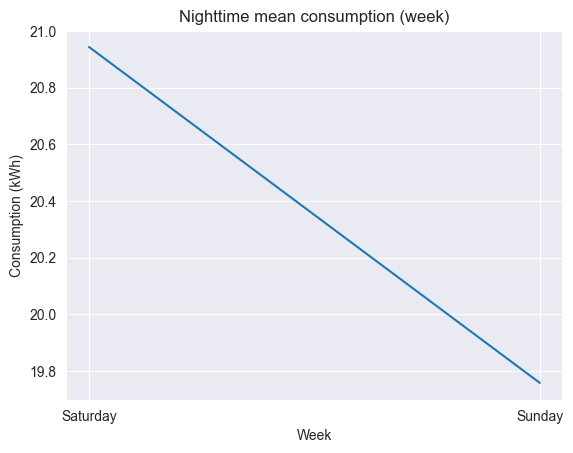

In [129]:
sns.lineplot(
    data=user_data_nighttime_weekend,
    x='Weekend',
    y='Verbrauch (kWh)',
    ci=None
)
plt.xlabel('Week')
plt.ylabel('Consumption (kWh)')
plt.title('Nighttime mean consumption (week)')
plt.xticks([6, 7], labels=['Saturday', 'Sunday'])
plt.savefig('Images/Public/nighttime-demand-profile-weekend')
plt.show()

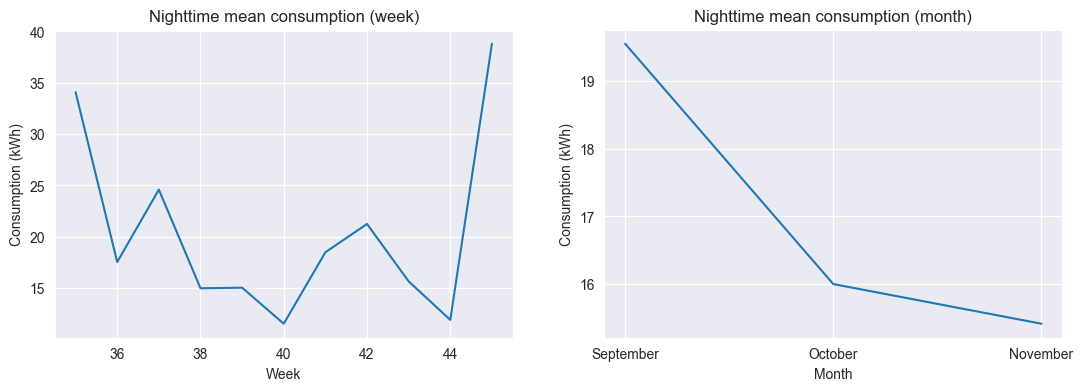

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# Rate of charge (weekly)
sns.lineplot(
    data=user_data_nighttime,
    x='Plugged_in_week',
    y='Verbrauch (kWh)',
    ax=ax[0],
    ci=None
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Consumption (kWh)')
ax[0].set_title('Nighttime mean consumption (week)')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data_nighttime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax[1],
    ci=None
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Consumption (kWh)')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Nighttime mean consumption (month)')
plt.savefig('Images/Public/nighttime-demand-profile')
plt.show()